In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras.models import Model
from keras.losses import categorical_crossentropy

import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import dense

### Data

In [3]:
train_dict, train_files = data.get_data('train', keypoints=['Neck'])

preprocess True
keypoints ['Neck']
1.20681786537


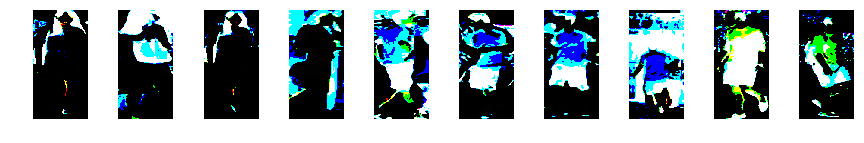

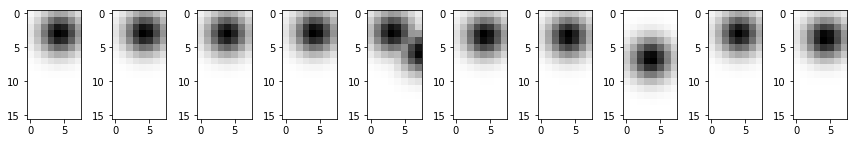

In [4]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=8, preprocess=True,
                                    shape=(256,128), keypoints=['Neck'], r=0.6,
                                    cam_output_dim=(16,8), cam_wide=False).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

import cv2
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    im = cv2.resize(batch[1]['cam_output'][i].squeeze(), (8,16))
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis('on')
plt.show()

### Train Network

In [5]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

In [6]:
# file_root = 'hip_cam_inverse'
# if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
#     os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [7]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 40.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

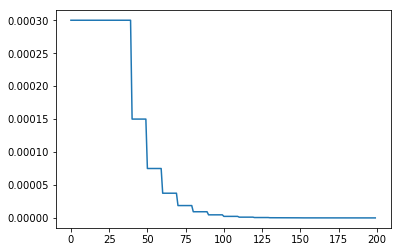

In [8]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [9]:
P_param = 5
K_param = 4

def_triplet_loss = """

import keras.backend as Keras

def triplet_loss(y_true, y_pred, margin=1.0, P=%d, K=%d, output_dim=%d):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))
    loss = Keras.variable(0, dtype='float32')

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(triplet.dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(triplet.dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                    embeddings[(i + 1)*K:]], 0)))
            if margin == 'soft':
                loss += triplet.log1p(hard_pos - hard_neg)
            else:
                loss += Keras.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss
""" % (P_param, K_param, 128)

exec(def_triplet_loss)

def cam_loss(y_true, y_pred, P=P_param, K=K_param, cam_dim=(16,8)):
#     return tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
#     return Keras.sum(triplet.norm(y_true, y_pred, axis=(1,2), norm=1))
#     return tf.losses.hinge_loss(labels=y_true, logits=y_pred)
    return Keras.sum(Keras.flatten(tf.multiply(y_true, y_pred)))

In [10]:
trinet = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), weights='imagenet')

Weights for the model were loaded successfully


In [11]:
trinet.layers[-6]

In [12]:
from keras.layers import Lambda

def norm(im, cam_dim=(16,8)):
    im = tf.image.resize_images(im, cam_dim)
    im_transpose = tf.transpose(im, perm=[0, 3, 1, 2])
    cam_min = tf.tile(tf.reshape(Keras.min(im_transpose, axis=(2,3)), 
                                 (-1, im_transpose.get_shape().as_list()[1], 1, 1)), 
                      (1,1,cam_dim[0],cam_dim[1]))
    cam_norm = im_transpose - cam_min
#     cam_max = tf.tile(tf.reshape(Keras.max(cam_norm, axis=(2,3)), 
#                                  (-1, im_transpose.get_shape().as_list()[1], 1, 1)), 
#                       (1,1,cam_dim[0],cam_dim[1]))
#     cam_norm = tf.div(cam_norm, cam_max + 1e-10)
    cam_norm = tf.transpose(cam_norm, perm=[0,2,3,1])
    return cam_norm
    
def cam(im, cam_dim=(16,8)):
    cam_mean = Keras.mean(tf.image.resize_images(im, cam_dim), axis=3)
    cam_max = tf.tile(tf.reshape(Keras.max(cam_mean, axis=(1,2)), (-1, 1, 1)), (1,cam_dim[0],cam_dim[1]))
    cam_norm = tf.div(cam_mean, cam_max)
    return cam_mean

x = Lambda(norm, name='norm')(trinet.layers[-6].output)
cam_output = Lambda(cam, name='cam_output')(x)

In [13]:
camnet = Model(inputs=trinet.input, outputs=[trinet.output, cam_output])
camnet.compile(loss=[triplet_loss, cam_loss], loss_weights=[1.0, 0.2],
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [14]:
camnet.output

[<tf.Tensor 'final_output/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'cam_output/Mean:0' shape=(?, 16, 8) dtype=float32>]

In [15]:
camnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [16]:
for l in range(len(camnet.layers)):
    if camnet.layers[l].name.find('average_pooling2d') > -1:
        print l

50
138
310
426


In [17]:
camnet.layers[-3]

In [18]:
base_cam = Model(inputs=camnet.input, outputs=camnet.layers[-1].output)
base_cam.compile(loss=categorical_crossentropy,
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [19]:
cam_b = base_cam.predict(batch[0]['input_im'][1].reshape((1,256,128,3)))[0]

In [20]:
cam_b.shape

(16, 8)

In [21]:
cam_b.min(), cam_b.max()

(0.14243905, 0.73746574)

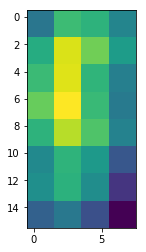

In [22]:
plt.imshow(cam_b)

In [23]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.final_output_loss = []
        self.cam_output_loss = []
        
    def on_epoch_end(self, epoch, logs={}):
#         print logs.keys()
        self.loss.append(logs['loss'])
        self.final_output_loss.append(logs['final_output_loss'])
        self.cam_output_loss.append(logs['cam_output_loss'])
    
    def on_train_end(self, logs={}):
        print self.loss, self.final_output_loss, self.cam_output_loss

In [24]:
# model_json = camnet.to_json()
# with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
#     json_file.write(model_json)

In [25]:
# camnet.set_weights(np.load('/home/albert/github/tensorflow/models/densenet_cam_l1_test/densenet_cam_l1_test_5000.npy'))

In [26]:
train_score = {}
hist = {'loss' : [], 'final_output_loss' : [], 'cam_output_loss' : []}
history = History()
loss = LossHistory()

In [27]:
for era in range(1,11):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    camnet.fit_generator(data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=preprocess,
                                                     shape=input_shape, keypoints=['Neck'], r=0.6,
                                                     cam_wide=False,
                                                     cam_output_dim=(16,8)), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history, loss])
    
#     file_name = file_root + '_' + str(iterations) + '.npy'
#     np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), camnet.get_weights())
    
    train_score[iterations] = evaluation.get_score(camnet, hist=history, preprocess=preprocess)
    
    hist['loss'] += loss.loss
    hist['final_output_loss'] += loss.final_output_loss
    hist['cam_output_loss'] += loss.cam_output_loss
    
    print iterations, train_score[iterations]

preprocess True
keypoints ['Neck']
Epoch 1/10
100/100 [==============================] - 79s - loss: 492.6317 - final_output_loss: 315.0842 - cam_output_loss: 886.1789    
Epoch 2/10
100/100 [==============================] - 72s - loss: 378.1828 - final_output_loss: 215.4848 - cam_output_loss: 811.9183    
Epoch 3/10
100/100 [==============================] - 72s - loss: 338.2547 - final_output_loss: 179.2857 - cam_output_loss: 793.2646    
Epoch 4/10
100/100 [==============================] - 71s - loss: 284.5493 - final_output_loss: 133.9297 - cam_output_loss: 751.5112    
Epoch 5/10
100/100 [==============================] - 72s - loss: 265.4509 - final_output_loss: 123.1275 - cam_output_loss: 710.0258    
Epoch 6/10
100/100 [==============================] - 71s - loss: 232.7720 - final_output_loss: 95.8671 - cam_output_loss: 682.9294    
Epoch 7/10
100/100 [==============================] - 72s - loss: 235.3256 - final_output_loss: 102.1708 - cam_output_loss: 664.1746    
Epoch 8

KeyboardInterrupt: 

In [20]:
# np.save('/home/albert/inverse_history.npy', hist)

In [24]:
# np.save('/home/albert/hip_cam_inverse.npy', camnet.get_weights())

In [25]:
# np.savez('/home/albert/hip_cam_inverse_history.npz' , hist)
# np.savez('/home/albert/hip_cam_inverse_score.npz' , train_score)

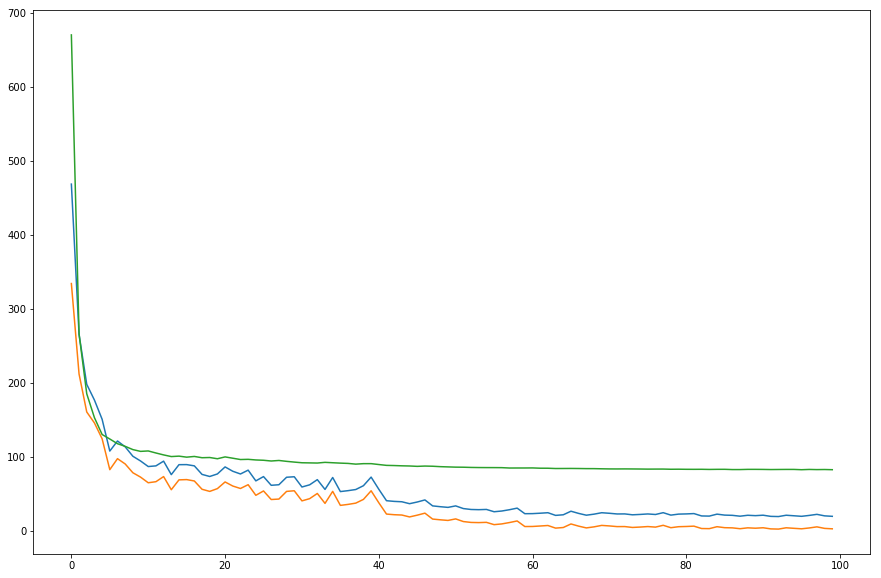

In [26]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(100), hist['loss'], 
         np.arange(100), hist['final_output_loss'], 
         np.arange(100), hist['cam_output_loss'])

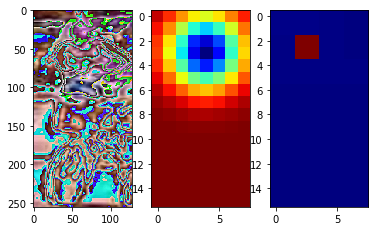

In [56]:
n = 20
cam = camnet.predict(batch[0]['input_im'][n].reshape((1,256,128,3)))[1][0]
plt.subplot(131)
plt.imshow(batch[0]['input_im'][n])
plt.subplot(132)
plt.imshow(batch[1]['cam_output'][n], cmap=plt.cm.jet)
plt.subplot(133)
plt.imshow(cam, cmap=plt.cm.jet)
plt.show()

In [57]:
print np.sum(np.multiply(cam, batch[1]['cam_output'][n]))

1.28595887822


(array([ 124.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    4.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

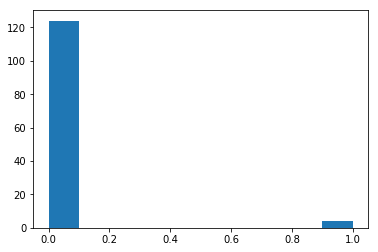

In [58]:
plt.hist(cam.flatten())

### Evaluation

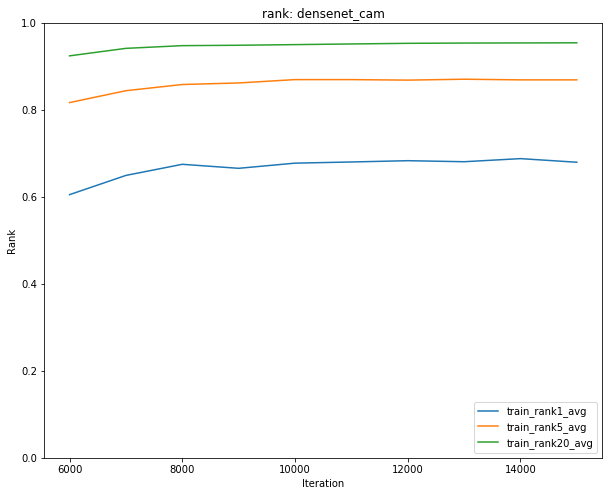

iterations 14000
best_train {1: 0.68794536817102137, 20: 0.95397862232779096, 5: 0.86906175771971494}


In [24]:
evaluation.plot_rank('densenet_cam', ylim_0=0.0)

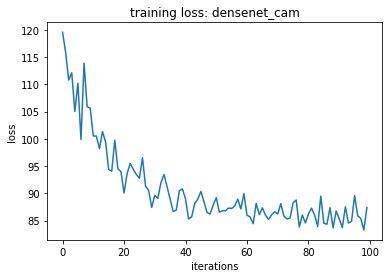

In [25]:
evaluation.plot_loss('densenet_cam')

In [ ]:
evaluation.plot_rank('densenet_triplet_front', ylim_0=0.0)

In [ ]:
camnet.set_weights(np.load('/home/albert/camnet_1000.npy'))

In [60]:
from keras.models import load_model
camnet.set_weights(np.load('/home/albert/github/tensorflow/models/hip_cam_inverse/hip_cam_inverse_1000.npy'))
# model = load_model('/home/albert/github/tensorflow/pre/models/densenet_triplet_margin_preprocess/densenet_triplet_margin_preprocess_13000.h5', 
#                    custom_objects={'triplet_loss' : triplet.triplet_loss})

0.0273109


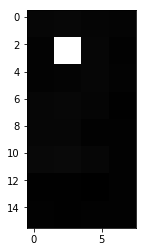

In [69]:
cam = camnet.predict(batch[0]['input_im'][6].reshape((1,256,128,3)))[1][0]
plt.imshow(cam, cmap=plt.cm.gray)
print cam[10,4]

In [83]:
camnet.layers[310]

In [108]:
base_cam = Model(inputs=camnet.input, outputs=camnet.layers[-7].output)
base_cam.compile(loss=categorical_crossentropy,
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [109]:
cam_b = base_cam.predict(batch[0]['input_im'][5].reshape((1,256,128,3)))[0]

In [110]:
cam_b.shape

(16, 8, 1024)

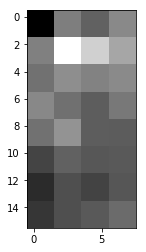

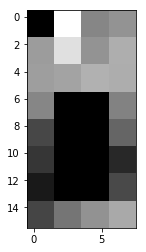

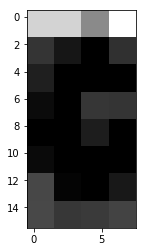

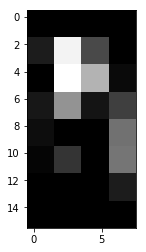

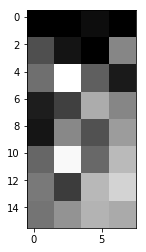

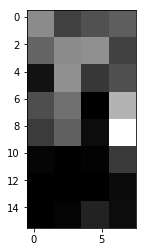

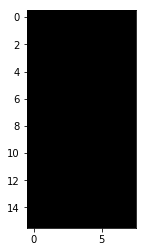

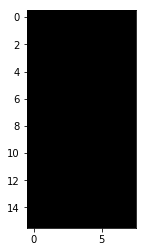

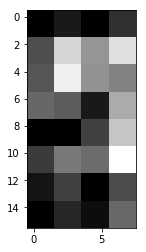

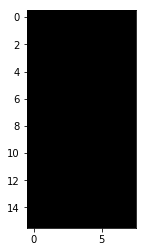

In [112]:
for c in range(10):
    plt.imshow(cam_b[..., c], cmap=plt.cm.gray)
    plt.show()

In [101]:
cam_mean = np.mean(cam_b, axis=2)

In [102]:
print cam_mean.min(), cam_mean.max()

-0.338378 -0.160754


(array([ 1.,  0.,  1.,  1.,  3.,  6.,  6.,  6.,  4.,  4.]),
 array([-0.33837777, -0.32061543, -0.30285308, -0.28509073, -0.26732838,
        -0.24956603, -0.23180369, -0.21404134, -0.19627899, -0.17851664,
        -0.16075429]),
 <a list of 10 Patch objects>)

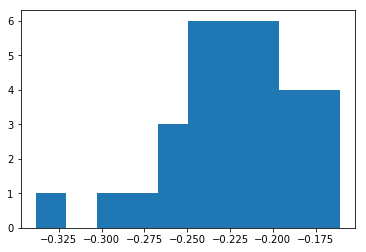

In [103]:
plt.hist(cam_mean.flatten(), bins=10)

In [104]:
cam_norm = cam_mean - cam_mean.min()
cam_norm = cam_norm / cam_norm.max()

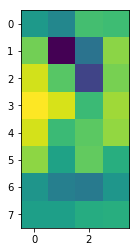

In [105]:
plt.imshow((255 * cam_norm).astype(np.uint8))

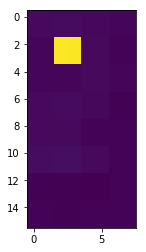

In [91]:
plt.imshow((255 * cam).astype(np.uint8))